In [1]:
from pyspark.sql import SparkSession

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import seaborn as sns
from pyspark.sql.functions import format_number
import pyspark.sql.functions as F

In [3]:
spark = SparkSession.builder.appName("features").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 08:48:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
events = spark.read.csv('Data/events.csv',header=True,inferSchema=True,sep=';')

In [5]:
shots = events.filter(events.type == 'Shot')

## Numerical Variables

### Location

In [7]:
shots.select('type','location','shot_statsbomb_xg').show(5,False)

+----+-------------+-----------------+
|type|location     |shot_statsbomb_xg|
+----+-------------+-----------------+
|Shot|[105.6, 44.0]|0.07213958       |
|Shot|[98.6, 25.2] |0.02977089       |
|Shot|[105.5, 47.3]|0.07589752       |
|Shot|[113.4, 38.7]|0.15686217       |
|Shot|[106.2, 36.8]|0.15133068       |
+----+-------------+-----------------+
only showing top 5 rows



## Categorical Variables

### Play pattern

In [8]:
shots.select('type','play_pattern','shot_statsbomb_xg').show(5,False)

+----+-------------+-----------------+
|type|play_pattern |shot_statsbomb_xg|
+----+-------------+-----------------+
|Shot|From Kick Off|0.07213958       |
|Shot|From Keeper  |0.02977089       |
|Shot|From Throw In|0.07589752       |
|Shot|From Corner  |0.15686217       |
|Shot|From Throw In|0.15133068       |
+----+-------------+-----------------+
only showing top 5 rows



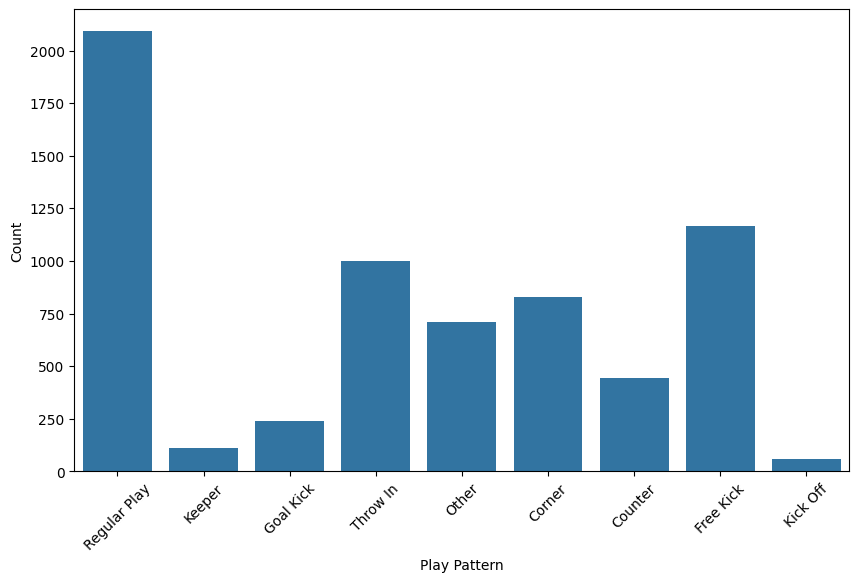

In [9]:
goal_shots = shots.filter(shots['shot_outcome'] == 'Goal')
goal_play_pattern_counts = goal_shots.groupBy("play_pattern").count()
goal_play_pattern_counts_list = goal_play_pattern_counts.collect()
goal_play_patterns = [row['play_pattern'] for row in goal_play_pattern_counts_list]
goal_counts = [row['count'] for row in goal_play_pattern_counts_list]
goal_play_patterns = [pattern.replace("From ", "") if pattern != "Other" else pattern for pattern in goal_play_patterns]
plt.figure(figsize=(10, 6))
sns.barplot(x=goal_play_patterns, y=goal_counts, color='#1F77B4')
plt.xlabel('Play Pattern')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

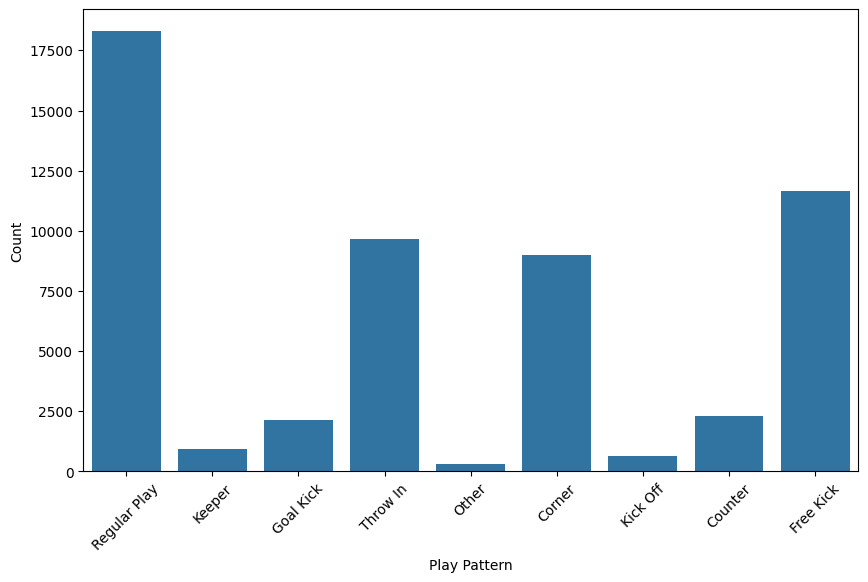

In [10]:
goal_shots = shots.filter(shots['shot_outcome'] != 'Goal')
goal_play_pattern_counts = goal_shots.groupBy("play_pattern").count()
goal_play_pattern_counts_list = goal_play_pattern_counts.collect()
goal_play_patterns = [row['play_pattern'] for row in goal_play_pattern_counts_list]
goal_counts = [row['count'] for row in goal_play_pattern_counts_list]
goal_play_patterns = [pattern.replace("From ", "") if pattern != "Other" else pattern for pattern in goal_play_patterns]
plt.figure(figsize=(10, 6))
sns.barplot(x=goal_play_patterns, y=goal_counts, color='#1F77B4')
plt.xlabel('Play Pattern')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Shot Type

In [ ]:
unique_shot_types = shots.select('type', 'shot_type', 'shot_statsbomb_xg').dropDuplicates(['shot_type'])
formatted_shot_types = unique_shot_types.withColumn(
    'shot_statsbomb_xg', format_number('shot_statsbomb_xg', 6))
formatted_shot_types.show(truncate=False)

+----+---------+-----------------+
|type|shot_type|shot_statsbomb_xg|
+----+---------+-----------------+
|Shot|Corner   |0.000180         |
|Shot|Free Kick|0.039566         |
|Shot|Open Play|0.072140         |
|Shot|Penalty  |0.783500         |
+----+---------+-----------------+



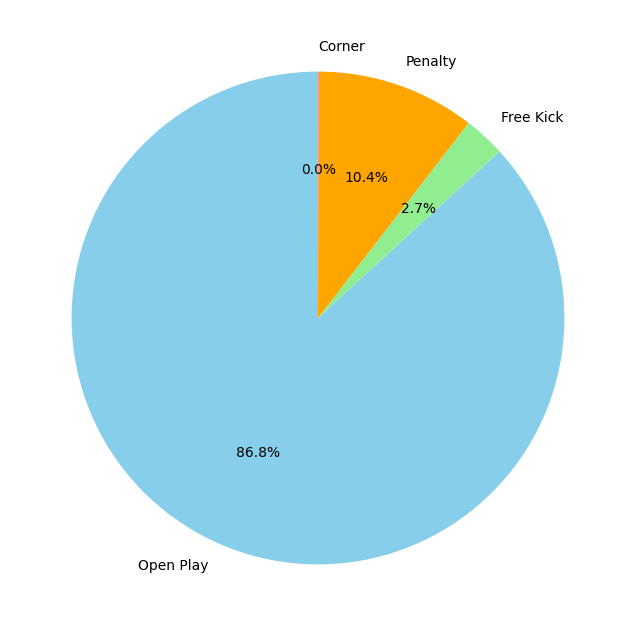

In [19]:
shot_type_count = shots.filter(shots['shot_outcome'] == 'Goal').groupBy("shot_type").agg(F.count("shot_type").alias("count"))
shot_type_data = shot_type_count.collect()
labels = [row['shot_type'] for row in shot_type_data]
sizes = [row['count'] for row in shot_type_data]
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
plt.show()

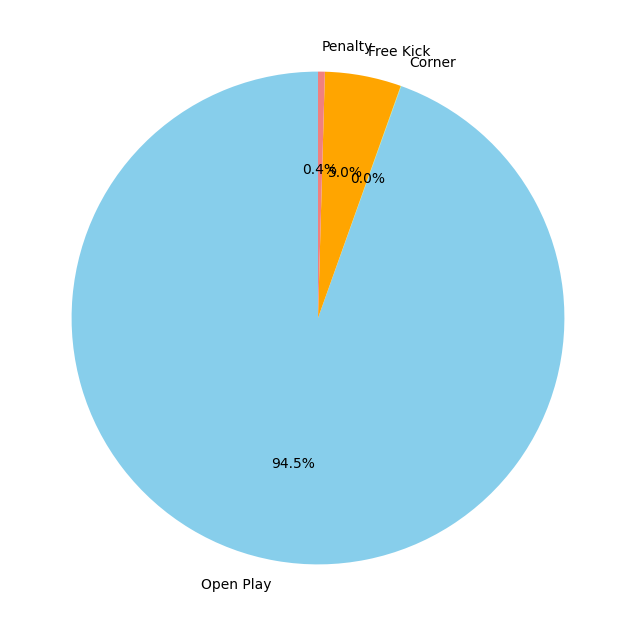

In [21]:
shot_type_count = shots.filter(shots['shot_outcome'] != 'Goal').groupBy("shot_type").agg(F.count("shot_type").alias("count"))
shot_type_data = shot_type_count.collect()
labels = [row['shot_type'] for row in shot_type_data]
sizes = [row['count'] for row in shot_type_data]
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
plt.show()

### Shot Body Part

In [16]:
shots.select('type','shot_body_part','shot_statsbomb_xg').show(5,False)

+----+--------------+-----------------+
|type|shot_body_part|shot_statsbomb_xg|
+----+--------------+-----------------+
|Shot|Right Foot    |0.07213958       |
|Shot|Right Foot    |0.02977089       |
|Shot|Right Foot    |0.07589752       |
|Shot|Head          |0.15686217       |
|Shot|Left Foot     |0.15133068       |
+----+--------------+-----------------+
only showing top 5 rows



In [17]:
shots.groupBy('shot_body_part').count().show()

+--------------+-----+
|shot_body_part|count|
+--------------+-----+
|    Right Foot|31623|
|     Left Foot|19880|
|          Head| 9922|
|         Other|  183|
+--------------+-----+



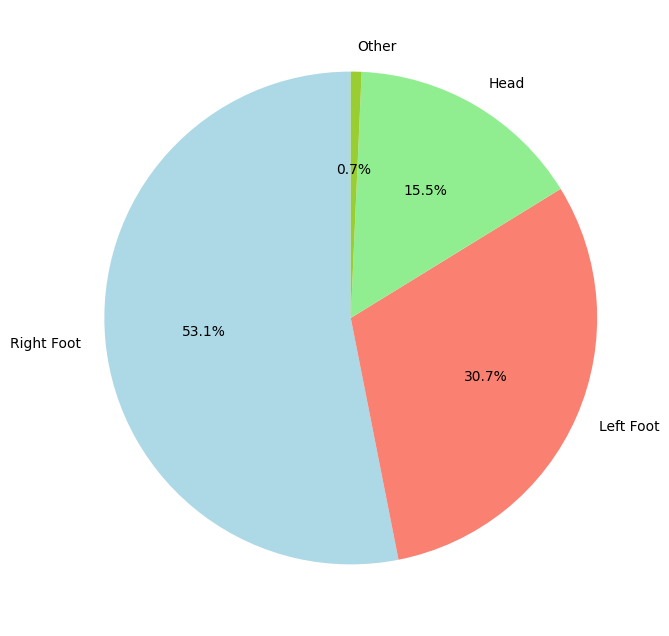

In [23]:
shot_body_part_count = shots.filter(shots['shot_outcome']=='Goal').groupBy("shot_body_part").agg(F.count("shot_body_part").alias("count"))
shot_body_part_data = shot_body_part_count.collect()
labels = [row['shot_body_part'] for row in shot_body_part_data]
sizes = [row['count'] for row in shot_body_part_data]
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'salmon', 'lightgreen', 'yellowgreen']
)
plt.show()

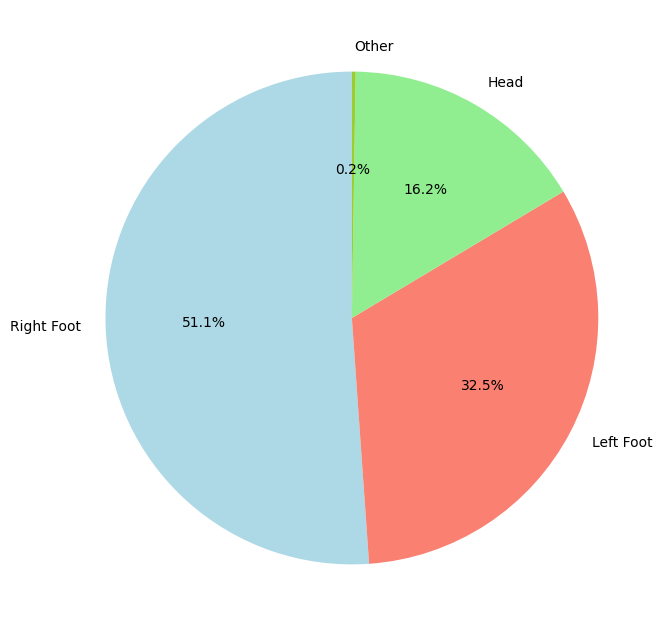

In [24]:
shot_body_part_count = shots.filter(shots['shot_outcome']!='Goal').groupBy("shot_body_part").agg(F.count("shot_body_part").alias("count"))
shot_body_part_data = shot_body_part_count.collect()
labels = [row['shot_body_part'] for row in shot_body_part_data]
sizes = [row['count'] for row in shot_body_part_data]
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'salmon', 'lightgreen', 'yellowgreen']
)
plt.show()

### Shot Technique

In [25]:
shots.select('type','shot_technique','shot_statsbomb_xg').show(5,False)

+----+--------------+-----------------+
|type|shot_technique|shot_statsbomb_xg|
+----+--------------+-----------------+
|Shot|Half Volley   |0.07213958       |
|Shot|Normal        |0.02977089       |
|Shot|Half Volley   |0.07589752       |
|Shot|Normal        |0.15686217       |
|Shot|Normal        |0.15133068       |
+----+--------------+-----------------+
only showing top 5 rows



In [26]:
shots.groupBy('shot_technique').count().show()

+--------------+-----+
|shot_technique|count|
+--------------+-----+
|      Backheel|  242|
| Diving Header|  239|
|   Half Volley| 8711|
| Overhead Kick|  351|
|        Volley| 4091|
|           Lob|  578|
|        Normal|47396|
+--------------+-----+



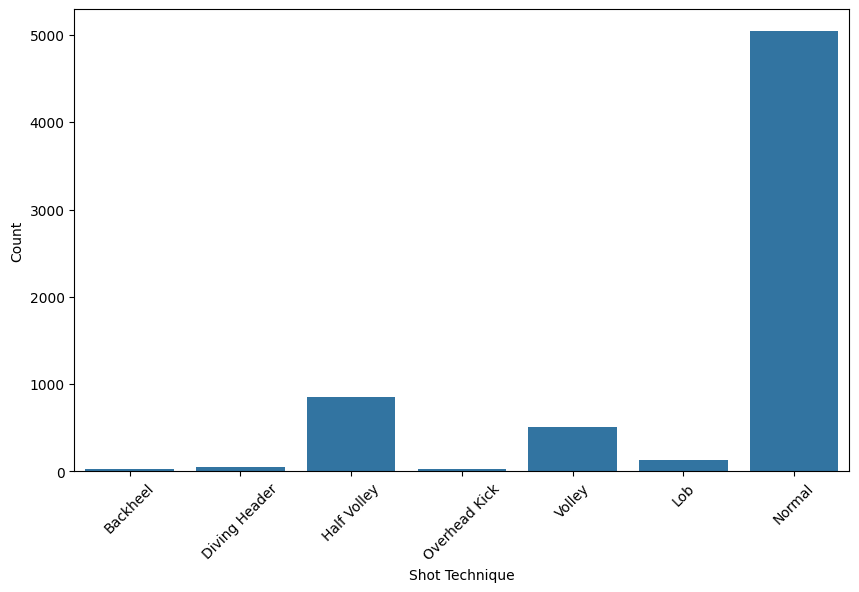

In [29]:
goal_shots = shots.filter(shots['shot_outcome'] == 'Goal')
goal_shot_technique_counts = goal_shots.groupBy("shot_technique").count()
goal_shot_technique_counts_list = goal_shot_technique_counts.collect()
goal_shot_techniques = [row['shot_technique'] for row in goal_shot_technique_counts_list]
goal_counts = [row['count'] for row in goal_shot_technique_counts_list]
goal_shot_techniques = [pattern.replace("From ", "") if pattern != "Other" else pattern for pattern in goal_shot_techniques]
plt.figure(figsize=(10, 6))
sns.barplot(x=goal_shot_techniques, y=goal_counts, color='#1F77B4')
plt.xlabel('Shot Technique')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

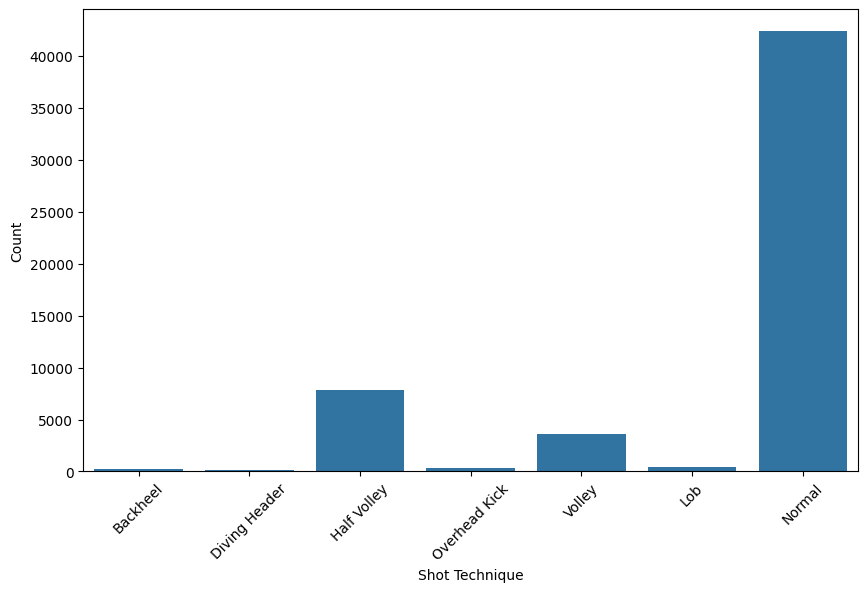

In [30]:
goal_shots = shots.filter(shots['shot_outcome'] != 'Goal')
goal_shot_technique_counts = goal_shots.groupBy("shot_technique").count()
goal_shot_technique_counts_list = goal_shot_technique_counts.collect()
goal_shot_techniques = [row['shot_technique'] for row in goal_shot_technique_counts_list]
goal_counts = [row['count'] for row in goal_shot_technique_counts_list]
goal_shot_techniques = [pattern.replace("From ", "") if pattern != "Other" else pattern for pattern in goal_shot_techniques]
plt.figure(figsize=(10, 6))
sns.barplot(x=goal_shot_techniques, y=goal_counts, color='#1F77B4')
plt.xlabel('Shot Technique')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Binary Variables

### Under Pressure

In [31]:
shots.select('type','under_pressure','shot_statsbomb_xg').show(5,False)

+----+--------------+-----------------+
|type|under_pressure|shot_statsbomb_xg|
+----+--------------+-----------------+
|Shot|NULL          |0.07213958       |
|Shot|NULL          |0.02977089       |
|Shot|true          |0.07589752       |
|Shot|true          |0.15686217       |
|Shot|NULL          |0.15133068       |
+----+--------------+-----------------+
only showing top 5 rows



### Shot First Time

In [39]:
shots.select('type','shot_first_time','shot_statsbomb_xg').show(5,False)

+----+---------------+-----------------+
|type|shot_first_time|shot_statsbomb_xg|
+----+---------------+-----------------+
|Shot|true           |0.07213958       |
|Shot|NULL           |0.02977089       |
|Shot|NULL           |0.07589752       |
|Shot|NULL           |0.15686217       |
|Shot|true           |0.15133068       |
+----+---------------+-----------------+
only showing top 5 rows



### Shot Aerial Won

In [41]:
shots.select('type','shot_aerial_won','shot_statsbomb_xg').show(5,False)

+----+---------------+-----------------+
|type|shot_aerial_won|shot_statsbomb_xg|
+----+---------------+-----------------+
|Shot|NULL           |0.07213958       |
|Shot|NULL           |0.02977089       |
|Shot|NULL           |0.07589752       |
|Shot|true           |0.15686217       |
|Shot|NULL           |0.15133068       |
+----+---------------+-----------------+
only showing top 5 rows



### Shot One on One

In [43]:
shots.select('type','shot_one_on_one','shot_statsbomb_xg').show(5,False)

+----+---------------+-----------------+
|type|shot_one_on_one|shot_statsbomb_xg|
+----+---------------+-----------------+
|Shot|NULL           |0.07213958       |
|Shot|NULL           |0.02977089       |
|Shot|NULL           |0.07589752       |
|Shot|NULL           |0.15686217       |
|Shot|NULL           |0.15133068       |
+----+---------------+-----------------+
only showing top 5 rows



### Shot Open Goal

In [44]:
shots.select('type','shot_open_goal','shot_statsbomb_xg').show(5,False)

+----+--------------+-----------------+
|type|shot_open_goal|shot_statsbomb_xg|
+----+--------------+-----------------+
|Shot|NULL          |0.07213958       |
|Shot|NULL          |0.02977089       |
|Shot|NULL          |0.07589752       |
|Shot|NULL          |0.15686217       |
|Shot|NULL          |0.15133068       |
+----+--------------+-----------------+
only showing top 5 rows



### Shot Follows Dribble

In [45]:
shots.select('type','shot_follows_dribble','shot_statsbomb_xg').show(5,False)

+----+--------------------+-----------------+
|type|shot_follows_dribble|shot_statsbomb_xg|
+----+--------------------+-----------------+
|Shot|NULL                |0.07213958       |
|Shot|NULL                |0.02977089       |
|Shot|NULL                |0.07589752       |
|Shot|NULL                |0.15686217       |
|Shot|NULL                |0.15133068       |
+----+--------------------+-----------------+
only showing top 5 rows



## Engineered Variables

In [10]:
import xG_preprocessing as pp

In [12]:
shots_pp = pp.preprocessing(shots,spark)

Data loaded
Spatial data calculated
Preferred foot calculated
Goal column created


Number of players inside the area calculated
Dummies created
Boolean data converted to integer


In [14]:
shots_pp = spark.read.csv('Data/Datas/shots.csv',header=True,inferSchema=True)

In [190]:
# take a random shot from the dataset
row = shots_pp.filter(shots_pp['under_pressure']==1).filter(shots_pp['players_inside_area']>3).collect()[0]

### Distance to goal

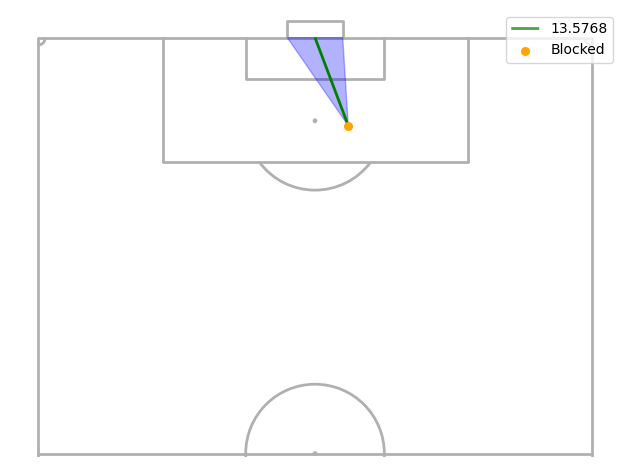

In [200]:
pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')

# Draw pitch and scatter shots
fig, ax = pitch.draw()

area = pitch.goal_angle(x=row['shot_location_x'],y=row['shot_location_y'],goal='right',ax=ax,color='blue',alpha=0.3,zorder=1)
l3 = pitch.lines(xstart=row['shot_location_x'],ystart=row['shot_location_y'],xend=120,yend=40,ax=ax,lw=2,label=row['distance_to_goal'],color='green')
sc1 = pitch.scatter(row['shot_location_x'], row['shot_location_y'], color='orange', s=30, label=row['shot_outcome'], ax=ax,zorder=2)

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Angle to goal

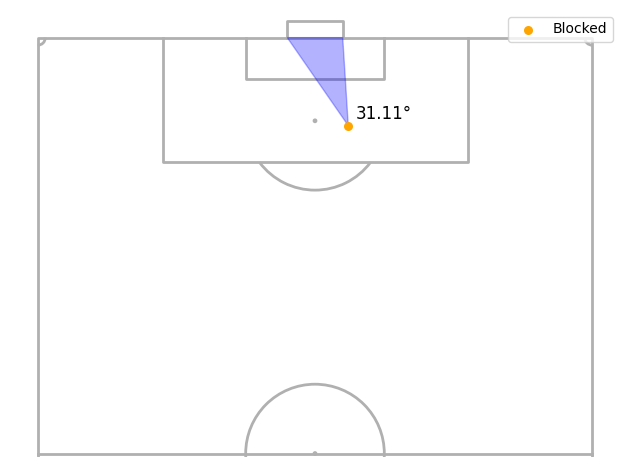

In [199]:
pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')

# Draw pitch and scatter shots
fig, ax = pitch.draw()

area = pitch.goal_angle(x=row['shot_location_x'],y=row['shot_location_y'],goal='right',ax=ax,color='blue',alpha=0.3,zorder=1)
sc1 = pitch.scatter(row['shot_location_x'], row['shot_location_y'], color='orange', s=30, label=row['shot_outcome'], ax=ax,zorder=2)
an = pitch.annotate(str(round(row['shot_angle'],2))+"°",(row['shot_location_x']+1, row['shot_location_y']+1),ax=ax,zorder=3,fontsize=12)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Players Inside Area

In [193]:
shot_freeze_frame = pp.shot_frame_to_df(events.filter(events['id']==row['id']))

In [194]:
shot_freeze_frame

,Shot_id,x,y,position,teammate
0,7373e8da-62d6-48a5-b8df-5c50fae624e6,112.1,60.1,Left Wing Back,False
1,7373e8da-62d6-48a5-b8df-5c50fae624e6,108.6,48.1,Left Defensive Midfield,False
2,7373e8da-62d6-48a5-b8df-5c50fae624e6,107.9,43.4,Right Defensive Midfield,False
3,7373e8da-62d6-48a5-b8df-5c50fae624e6,112.4,44.3,Left Center Back,False
4,7373e8da-62d6-48a5-b8df-5c50fae624e6,102.0,28.6,Right Wing,False
5,7373e8da-62d6-48a5-b8df-5c50fae624e6,113.3,41.6,Center Back,False
6,7373e8da-62d6-48a5-b8df-5c50fae624e6,112.9,35.9,Right Center Back,False
7,7373e8da-62d6-48a5-b8df-5c50fae624e6,109.5,26.0,Right Wing Back,False
8,7373e8da-62d6-48a5-b8df-5c50fae624e6,119.2,41.8,Goalkeeper,False
9,7373e8da-62d6-48a5-b8df-5c50fae624e6,94.8,53.7,Right Defensive Midfield,True


In [195]:
sff_c = shot_freeze_frame[shot_freeze_frame['teammate']=='True']
sff_o = shot_freeze_frame[shot_freeze_frame['teammate']=='False']

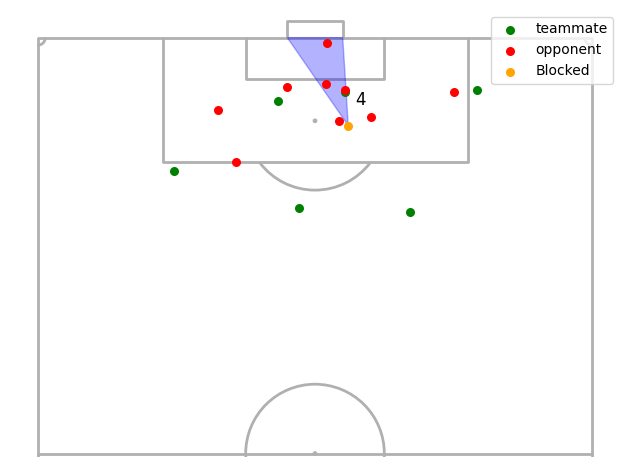

In [198]:
pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')

fig, ax = pitch.draw()
area = pitch.goal_angle(x=row['shot_location_x'],y=row['shot_location_y'],goal='right',ax=ax,color='blue',alpha=0.3,zorder=1)

c = pitch.scatter(sff_c['x'], sff_c['y'], color='green', s=30, label='teammate', ax=ax,zorder=2)
o = pitch.scatter(sff_o['x'], sff_o['y'], color='red', s=30, label='opponent', ax=ax,zorder=2)

sc1 = pitch.scatter(row['shot_location_x'], row['shot_location_y'], color='orange', s=30, label=row['shot_outcome'], ax=ax,zorder=2)

an = pitch.annotate(row['players_inside_area'],(row['shot_location_x']+3, row['shot_location_y']+1),ax=ax,zorder=3,fontsize=12)

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Pitch Visualization

In [56]:
df = events.toPandas()
# Set random seed for reproducibility
np.random.seed(42)

# Step 1: K-means clustering
k = 40  # Number of clusters
X = df[['shot_location_x', 'shot_location_y']].values

# Make KMeans reproducible
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [57]:

# Step 2: Sample from each cluster
sampled_df = df.groupby('cluster').apply(lambda x: x.sample(min(len(x), 25)))  # Sampling 25 shots per cluster, adjust as needed

# Check if the number of samples is greater than or equal to 3000
if len(sampled_df) > 1000:
    sampled_df = sampled_df.sample(n=1000, random_state=42)  # Get exactly 3000 samples
else:
    print(f"Number of samples is {len(sampled_df)}, which is less than 3000.")

Number of samples is 1000, which is less than 3000.


/tmp/ipykernel_31367/1546939458.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('cluster').apply(lambda x: x.sample(min(len(x), 25)))  # Sampling 25 shots per cluster, adjust as needed


In [58]:
sampled_df_g = sampled_df[sampled_df['goal'] == 1]
sampled_df_ng = sampled_df[sampled_df['goal'] == 0]

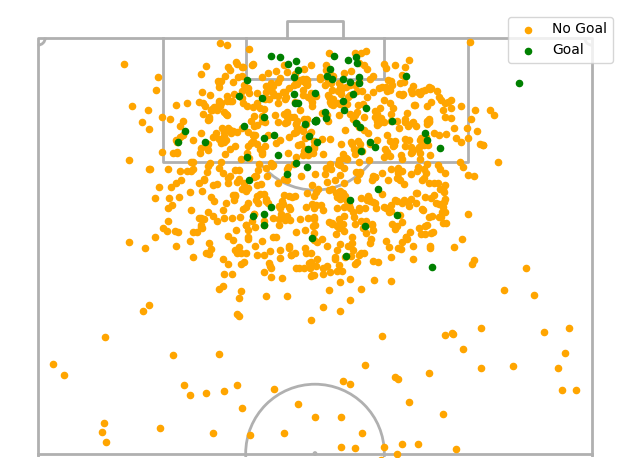

In [59]:
# Step 3: Plotting the representative sample on the pitch
# Fix figure size for consistency
pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')

# Draw pitch and scatter shots
fig, ax = pitch.draw()

sc1 = pitch.scatter(sampled_df_ng['shot_location_x'], sampled_df_ng['shot_location_y'], color='orange', s=20, label='No Goal', ax=ax)
sc2 = pitch.scatter(sampled_df_g['shot_location_x'], sampled_df_g['shot_location_y'], color='green', s=20, label='Goal', ax=ax)

# Add a legend in a fixed position
ax.legend(loc='upper right')

# Ensure consistent display
plt.tight_layout()
plt.show()

## Target Variables

In [202]:
shots.groupBy('shot_outcome').count().show()

+----------------+-----+
|    shot_outcome|count|
+----------------+-----+
|            Goal| 6651|
|           Saved|14531|
|           Off T|20011|
|         Blocked|15270|
|         Wayward| 3509|
|   Saved to Post|  198|
|Saved Off Target|  207|
|            Post| 1231|
+----------------+-----+

